# **Loading Libary and Dataset**

In [1]:
!pip install nltk

In [2]:
# imports the essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from textblob import TextBlob
from sklearn.manifold import TSNE

In [3]:
import re
import random
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from nltk.util import ngrams
from collections import Counter
from collections import Counter, defaultdict


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read the dataset from the specified path
df = pd.read_csv('/content/drive/MyDrive/CCNY/#2-ML/final project/#1-datasets/fake_real.csv', sep=',', encoding='utf-8', quotechar='"')
# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,Content,Title,Type
0,0,new york reuters us environmental group sierra...,politicsNews,true
1,1,washington reuters us air force asked industry...,politicsNews,true
2,2,saturday paul ryan posted photo instagram phot...,News,fake
3,3,america keeps waiting word hillary indicted ob...,politics,fake
4,4,religion peace ht weasel zippers,left-news,fake


In [7]:
# Display the last few rows of the DataFrame
df.tail()

,Unnamed: 0,Content,Title,Type
44893,44893,new york reuters myanmar national security adv...,worldnews,true
44894,44894,reckless hillary cared less seriousness exposi...,politics,fake
44895,44895,montevideo reuters lucia topolansky uruguay se...,worldnews,true
44896,44896,donald trump getting heavy media coverage late...,News,fake
44897,44897,jakarta reuters indonesian security forces eas...,worldnews,true


# **Data Preprocessing:**


In [8]:
# Get the dimensions of the DataFrame (rows, columns)
print("\nDimensions of the DataFrame:")
df.shape


Dimensions of the DataFrame:


(44898, 4)

In [9]:
# Get a concise summary of the DataFrame including column data types and non-null values
print("\nSummary of the DataFrame:")
df.info()


Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44898 non-null  int64 
 1   Content     44266 non-null  object
 2   Title       44898 non-null  object
 3   Type        44898 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [10]:
# Check for missing values in each column
print("\nMissing values in each column:")
df.isnull().sum()


Missing values in each column:


Unnamed: 0      0
Content       632
Title           0
Type            0
dtype: int64

In [11]:
# Remove rows with missing values
df= df.dropna()

# Fill missing values in 'Content' column with an empty string
df['Content'].fillna('', inplace=True)

# Fill missing values in 'Type' column with the mode
mode_value = df['Type'].mode()[0]
df['Type'].fillna(mode_value, inplace=True)

<ipython-input-11-529fe9219cbb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Content'].fillna('', inplace=True)
<ipython-input-11-529fe9219cbb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'].fillna(mode_value, inplace=True)


In [12]:
df.isnull().sum()

Unnamed: 0    0
Content       0
Title         0
Type          0
dtype: int64

In [13]:
# Summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
df.describe()


Summary statistics of numerical columns:


,Unnamed: 0
count,44266.000000
mean,22444.399901
std,12960.235898
min,0.000000
25%,11218.250000
50%,22443.500000
75%,33667.750000
max,44897.000000


In [14]:
df.columns

Index(['Unnamed: 0', 'Content', 'Title', 'Type'], dtype='object')

In [15]:
# Display unique values in the 'type' column
print("\nUnique values in the 'type' column:")
df['Type'].unique()


Unique values in the 'type' column:


array(['true', 'fake'], dtype=object)

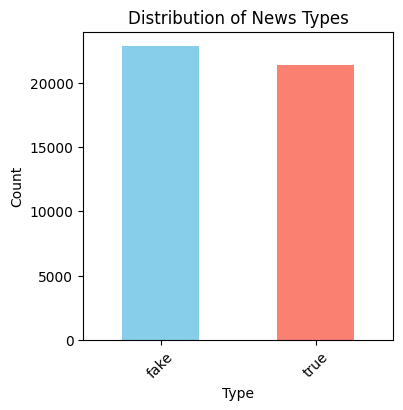

In [16]:
# Explore unique values in the 'Type' column
type_counts = df['Type'].value_counts()

# Define colors for different types
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral']

# Plot the counts
plt.figure(figsize=(4, 4))
type_counts.plot(kind='bar', color=colors)
plt.title('Distribution of News Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

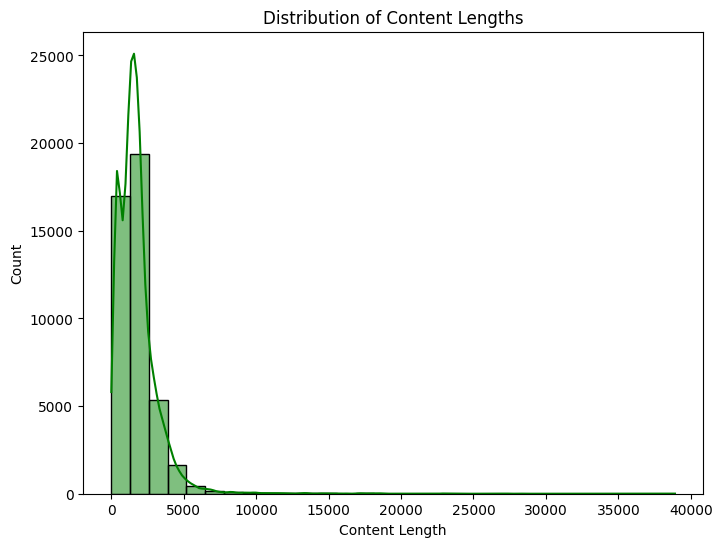

In [17]:
# Visualize the distribution of content lengths using a histogram
df['Content_Length'] = df['Content'].str.len()
plt.figure(figsize=(8, 6))
sns.histplot(df['Content_Length'], bins=30, kde=True, color='green')
plt.title('Distribution of Content Lengths')
plt.xlabel('Content Length')
plt.ylabel('Count')
plt.show()

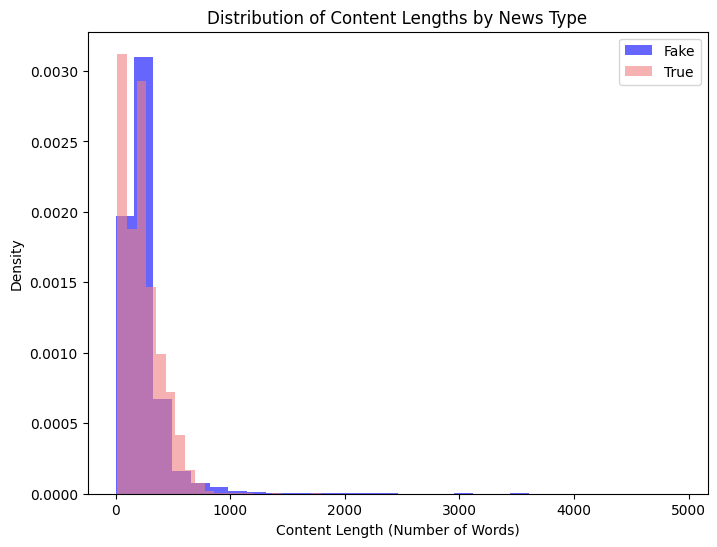

In [18]:
# Calculate the length of each article (number of words)
df['Content_Length'] = df['Content'].apply(lambda x: len(x.split()))

# Define colors for fake and true news
fake_color = 'blue'
true_color = 'lightcoral'

# Filter fake and true news
fake_news = df[df['Type'] == 'fake']
true_news = df[df['Type'] == 'true']

# Plot histograms for fake and true news
plt.figure(figsize=(8, 6))
plt.hist(fake_news['Content_Length'], bins=30, color=fake_color, label='Fake', alpha=0.6, density=True)
plt.hist(true_news['Content_Length'], bins=30, color=true_color, label='True', alpha=0.6, density=True)

plt.title('Distribution of Content Lengths by News Type')
plt.xlabel('Content Length (Number of Words)')
plt.ylabel('Density')
plt.legend()
plt.show()

**Clean the text data**

In [19]:
# Check if the Content column is of string data type
if df['Content'].dtype == 'object':
    print("The 'Content' column is of string data type.")
else:
    print("The 'Content' column is not of string data type.")

The 'Content' column is of string data type.


In [20]:
# convert Content column to string
df['Content'] = df['Content'].astype(str)

In [21]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text

# Apply the function to remove HTML tags from the 'Content' column
df['Content'] = df['Content'].apply(remove_html_tags)

**processing the text data**


In [22]:
# Function to remove punctuation marks from text
def remove_punctuation(text):
    # Define the regex pattern to match punctuation marks
    punctuation_pattern = r'[^\w\s]'
    # Replace punctuation marks with empty string
    cleaned_text = re.sub(punctuation_pattern, '', text)
    return cleaned_text

# Apply the function to remove punctuation from the 'Content' column
df['Content'] = df['Content'].apply(remove_punctuation)

In [23]:
# Function to remove special characters and numbers from text
def remove_special_characters_and_numbers(text):
    # Define the regex pattern to match special characters and numbers
    special_characters_and_numbers_pattern = r'[^a-zA-Z\s]'
    # Replace special characters and numbers with empty string
    cleaned_text = re.sub(special_characters_and_numbers_pattern, '', text)
    return cleaned_text

# Apply the function to remove special characters and numbers from the 'Content' column
df['Content'] = df['Content'].apply(remove_special_characters_and_numbers)

In [24]:
# Function to convert text to lowercase
def convert_to_lowercase(text):
    return text.lower()

# Apply the function to convert text to lowercase for the 'Content' column
df['Content'] = df['Content'].apply(convert_to_lowercase)

In [25]:
# Function to tokenize the text
def tokenize_text(text):
    return word_tokenize(text)

# Apply the function to tokenize the 'Content' column
df['Tokens'] = df['Content'].apply(tokenize_text)


In [26]:
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

# Apply the function to remove stopwords from the 'Tokens' column
df['Tokens'] = df['Tokens'].apply(remove_stopwords)

In [27]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply the function to lemmatize the 'Tokens' column
df['Tokens'] = df['Tokens'].apply(lemmatize_tokens)

In [28]:
# Function to join tokens back into a single string
def join_tokens(tokens):
    return ' '.join(tokens)

# Apply the function to join the processed tokens in the 'Tokens' column
df['Processed_Content'] = df['Tokens'].apply(join_tokens)

In [29]:
df.head()

,Unnamed: 0,Content,Title,Type,Content_Length,Tokens,Processed_Content
0,0,new york reuters us environmental group sierra...,politicsNews,true,294,"[new, york, reuters, u, environmental, group, ...",new york reuters u environmental group sierra ...
1,1,washington reuters us air force asked industry...,politicsNews,true,240,"[washington, reuters, u, air, force, asked, in...",washington reuters u air force asked industry ...
2,2,saturday paul ryan posted photo instagram phot...,News,fake,160,"[saturday, paul, ryan, posted, photo, instagra...",saturday paul ryan posted photo instagram phot...
3,3,america keeps waiting word hillary indicted ob...,politics,fake,641,"[america, keep, waiting, word, hillary, indict...",america keep waiting word hillary indicted oba...
4,4,religion peace ht weasel zippers,left-news,fake,5,"[religion, peace, ht, weasel, zipper]",religion peace ht weasel zipper


# **Visualization**

**Basic Statistics**

In [30]:
# Calculate basic statistics and plot for each type
types = df['Type'].unique()

for t in types:
    type_df = df[df['Type'] == t]
    num_documents = len(type_df)
    avg_length = type_df['Processed_Content'].apply(len).mean()
    max_length = type_df['Processed_Content'].apply(len).max()
    min_length = type_df['Processed_Content'].apply(len).min()

    print("\nType:", t)
    print("Number of documents:", num_documents)
    print("Average length of documents:", avg_length)
    print("Maximum length of documents:", max_length)
    print("Minimum length of documents:", min_length)



Type: true
Number of documents: 21416
Average length of documents: 1685.341753828913
Maximum length of documents: 18058
Minimum length of documents: 102

Type: fake
Number of documents: 22850
Average length of documents: 1760.9169803063457
Maximum length of documents: 37883
Minimum length of documents: 4


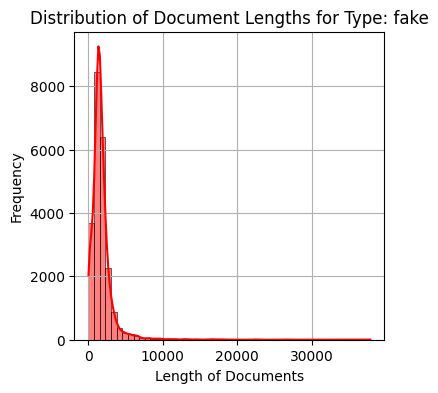

In [31]:
    # Plot distribution of document lengths with different colors
    color = 'red' if t == 'fake' else 'green'
    plt.figure(figsize=(4, 4))
    sns.histplot(type_df['Processed_Content'].apply(len), bins=50, kde=True, color=color)
    plt.title('Distribution of Document Lengths for Type: {}'.format(t))
    plt.xlabel('Length of Documents')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

**Vocabulary Analysis**


Type: true
Size of Vocabulary: 71250
Number of Rare Words (frequency = 1): 26237


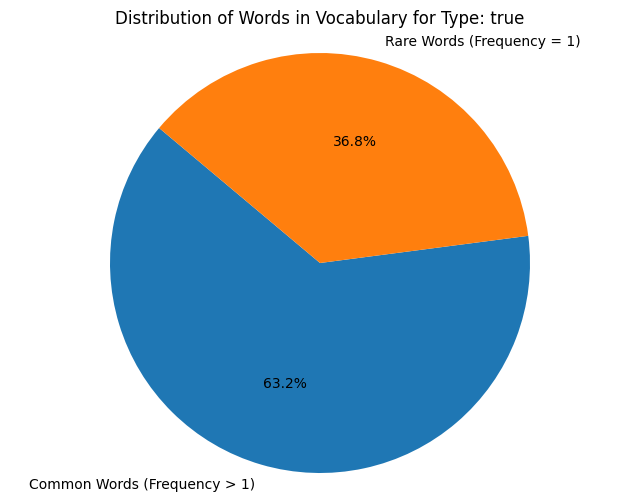


Type: fake
Size of Vocabulary: 168535
Number of Rare Words (frequency = 1): 75718


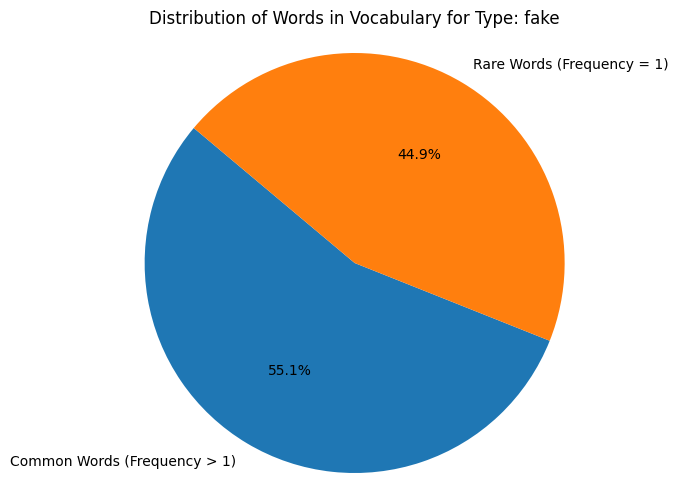

In [32]:
# Initialize an empty defaultdict to store word frequencies for each type
word_freq_by_type = defaultdict(lambda: defaultdict(int))

# Initialize variables to store vocabulary size and rare word count for each type
vocabulary_size_by_type = defaultdict(int)
num_rare_words_by_type = defaultdict(int)

# Set the batch size for updating word frequencies
batch_size = 1000  # Adjust as needed

# Iterate over each document to update word frequencies incrementally
for i, (tokens, type) in enumerate(zip(df['Tokens'], df['Type']), start=1):
    for token in tokens:
        word_freq_by_type[type][token] += 1  # Update word frequencies for each type

    # Update vocabulary size and count rare words after processing a batch of documents
    if i % batch_size == 0 or i == len(df):
        for t in word_freq_by_type.keys():
            vocabulary_size_by_type[t] = len(word_freq_by_type[t])
            num_rare_words_by_type[t] = sum(1 for freq in word_freq_by_type[t].values() if freq == 1)

# Output vocabulary statistics and plot the distribution of rare words versus common words for each type
for t in vocabulary_size_by_type.keys():
    print("\nType:", t)
    print("Size of Vocabulary:", vocabulary_size_by_type[t])
    print("Number of Rare Words (frequency = 1):", num_rare_words_by_type[t])

    # Plot the distribution of rare words versus common words for each type
    labels = ['Common Words (Frequency > 1)', 'Rare Words (Frequency = 1)']
    sizes = [vocabulary_size_by_type[t] - num_rare_words_by_type[t], num_rare_words_by_type[t]]

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Words in Vocabulary for Type: {}'.format(t))
    plt.axis('equal')
    plt.show()

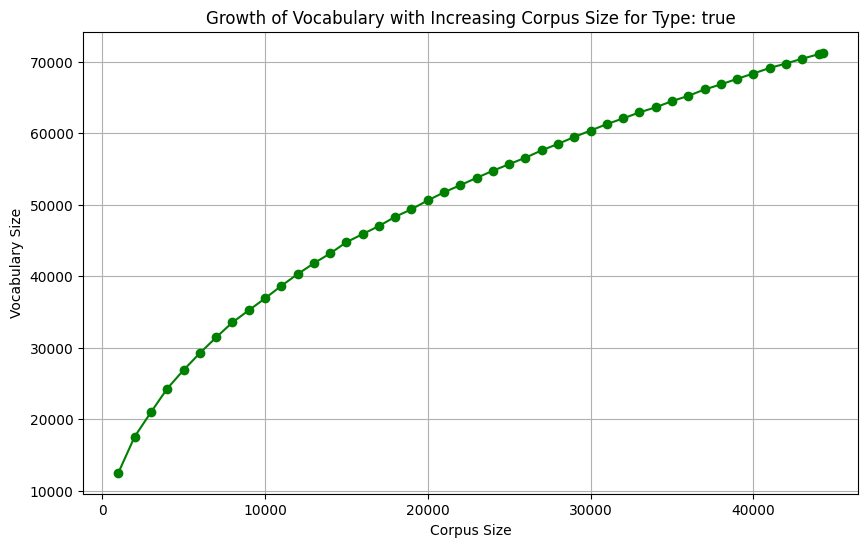

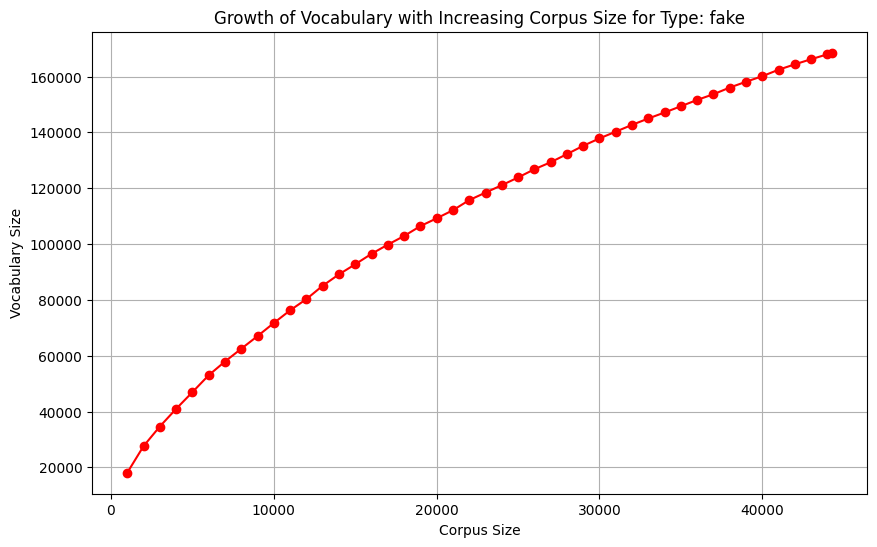

In [33]:
# Initialize an empty defaultdict to store word frequencies for each type
word_freq_by_type = defaultdict(lambda: defaultdict(int))

# Initialize a list to store vocabulary sizes for different corpus sizes for each type
vocabulary_sizes_by_type = defaultdict(list)
corpus_sizes = []

# Set the batch size for updating word frequencies
batch_size = 1000  # Adjust as needed

# Iterate over each document to update word frequencies incrementally
for i, (tokens, type) in enumerate(zip(df['Tokens'], df['Type']), start=1):
    for token in tokens:
        word_freq_by_type[type][token] += 1  # Update word frequencies for each type

    # Update vocabulary size after processing a batch of documents
    if i % batch_size == 0 or i == len(df):
        for t in word_freq_by_type.keys():
            vocabulary_size = len(word_freq_by_type[t])
            vocabulary_sizes_by_type[t].append(vocabulary_size)
        corpus_sizes.append(i)

# Plot the growth of vocabulary with increasing corpus size for each type
for t, vocabulary_sizes in vocabulary_sizes_by_type.items():
    color = 'red' if t == 'fake' else 'green'
    plt.figure(figsize=(10, 6))
    plt.plot(corpus_sizes, vocabulary_sizes, marker='o', color=color)
    plt.title('Growth of Vocabulary with Increasing Corpus Size for Type: {}'.format(t))
    plt.xlabel('Corpus Size')
    plt.ylabel('Vocabulary Size')
    plt.grid(True)
    plt.show()

**Sentiment Analysis**

0    0.080455
1    0.057019
2    0.039107
3    0.066206
4    0.000000
Name: Sentiment, dtype: float64


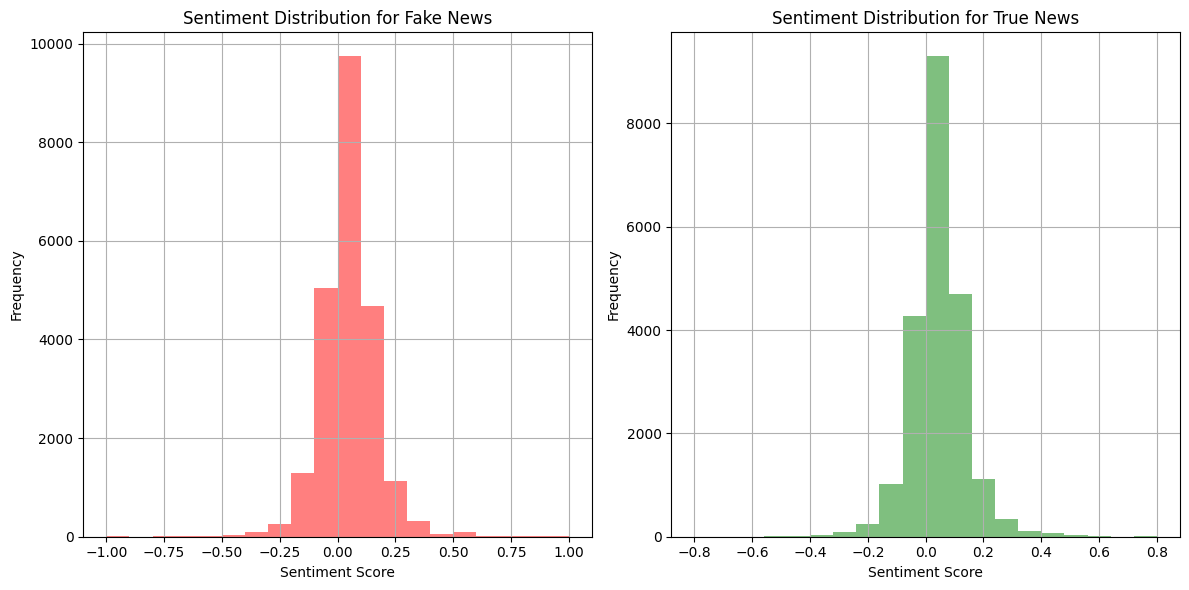

In [34]:
# Function to calculate sentiment score using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to each document
df['Sentiment'] = df['Content'].apply(get_sentiment)

# Print sentiment scores for the first few documents
print(df['Sentiment'].head())

# Create subplots for each type
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sentiment scores for 'fake' type
axes[0].hist(df[df['Type'] == 'fake']['Sentiment'], bins=20, color='red', alpha=0.5)
axes[0].set_title('Sentiment Distribution for Fake News')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot sentiment scores for 'true' type
axes[1].hist(df[df['Type'] == 'true']['Sentiment'], bins=20, color='green', alpha=0.5)
axes[1].set_title('Sentiment Distribution for True News')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Word Frequency Analysis: WordCloud for fake and real news separately**

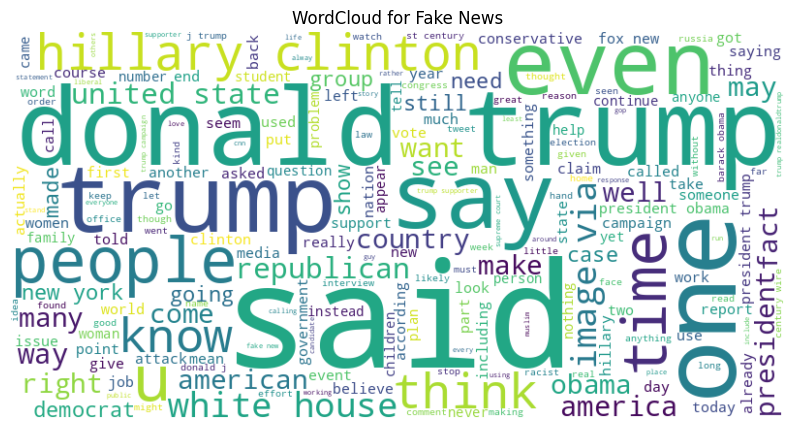

In [35]:
# Filter fake news
fake_news_text = ' '.join(df[df['Type'] == 'fake']['Content'])

# Generate WordCloud for fake news
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_news_text)

# Plot WordCloud for fake news
plt.figure(figsize=(10, 6))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('WordCloud for Fake News')
plt.axis('off')
plt.show()

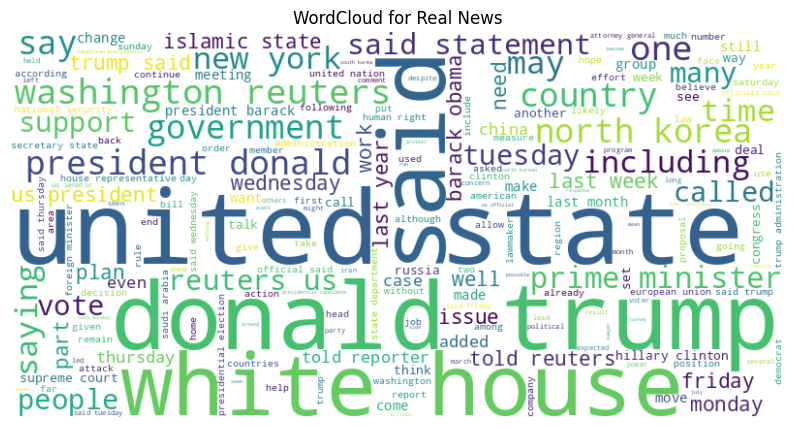

In [36]:
# Filter real news
real_news_text = ' '.join(df[df['Type'] == 'true']['Content'])

# Generate WordCloud for real news
real_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(real_news_text)

# Plot WordCloud for real news
plt.figure(figsize=(10, 6))
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.title('WordCloud for Real News')
plt.axis('off')
plt.show()

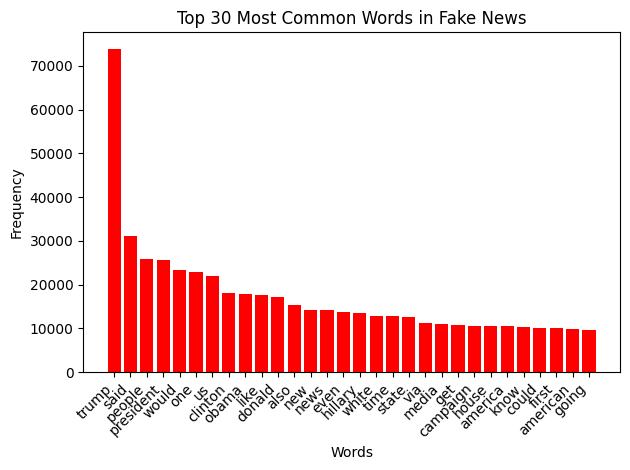

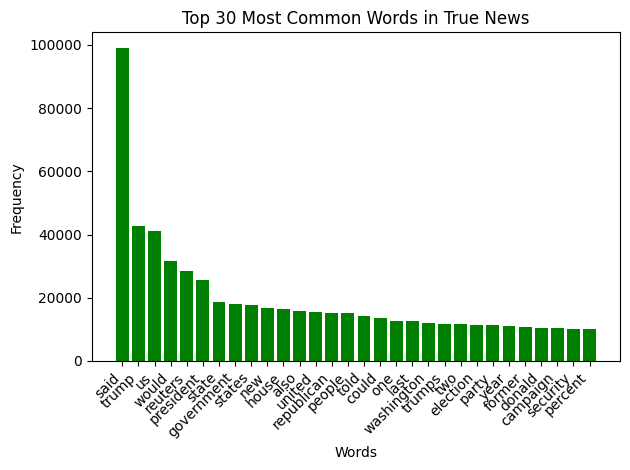

In [37]:
# Define a function to calculate word frequency and plot the bar chart
def plot_word_frequency(df, type_filter, top_n=10):
    # Filter data by type
    filtered_data = df[df['Type'] == type_filter]

    # Join all the content for the specified type
    text = ' '.join(filtered_data['Content'])

    # Tokenize the text
    tokens = text.split()

    # Calculate word frequency
    word_freq = Counter(tokens)

    # Get the top N most common words
    top_words = dict(word_freq.most_common(top_n))

    # Plot bar chart
    colors = ['red' if type_filter == 'fake' else 'green'] * top_n
    plt.bar(top_words.keys(), top_words.values(), color=colors)
    plt.title(f'Top {top_n} Most Common Words in {type_filter.capitalize()} News')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Specify the types for which you want to plot word frequency
types_to_plot = ['fake', 'true']

# Plot word frequency for each type
for t in types_to_plot:
    plot_word_frequency(df, t, top_n=30)

**Text Length Analysis**

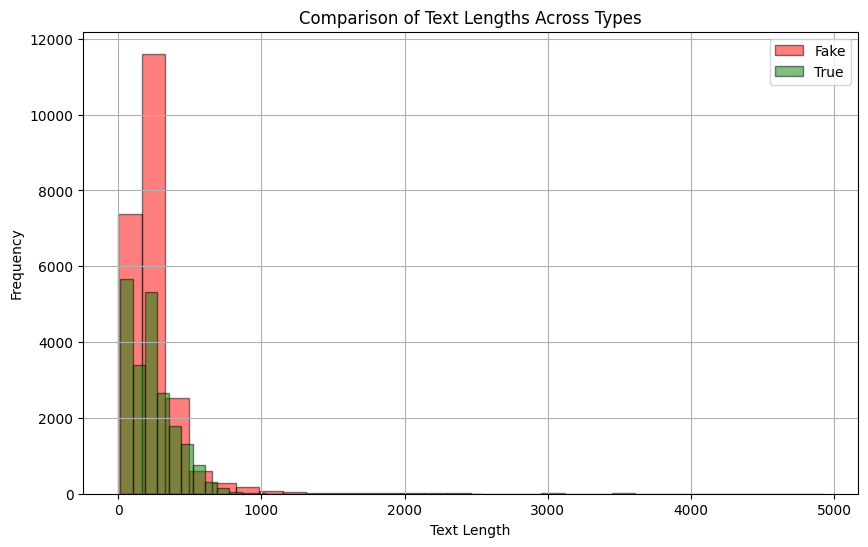

In [38]:
# Filter data for two types
type1_data = df[df['Type'] == 'fake']
type2_data = df[df['Type'] == 'true']

# Plot histogram for text lengths for each type
plt.figure(figsize=(10, 6))

# Plot histogram for type 1
plt.hist(type1_data['Content_Length'], bins=30, color='red', alpha=0.5, label='Fake', edgecolor='black')

# Plot histogram for type 2
plt.hist(type2_data['Content_Length'], bins=30, color='green', alpha=0.5, label='True', edgecolor='black')

plt.title('Comparison of Text Lengths Across Types')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

**Word Context Analysis**

In [39]:
# Filter data for two types
type1_data = df[df['Type'] == 'fake']
type2_data = df[df['Type'] == 'true']

# Initialize CountVectorizer to create co-occurrence matrix for type 1
vectorizer_type1 = CountVectorizer(ngram_range=(1, 2), max_features=1000)  # Adjust parameters as needed
co_occurrence_matrix_type1 = vectorizer_type1.fit_transform(type1_data['Processed_Content'])
feature_names_type1 = vectorizer_type1.get_feature_names_out()

# Initialize CountVectorizer to create co-occurrence matrix for type 2
vectorizer_type2 = CountVectorizer(ngram_range=(1, 2), max_features=1000)  # Adjust parameters as needed
co_occurrence_matrix_type2 = vectorizer_type2.fit_transform(type2_data['Processed_Content'])
feature_names_type2 = vectorizer_type2.get_feature_names_out()



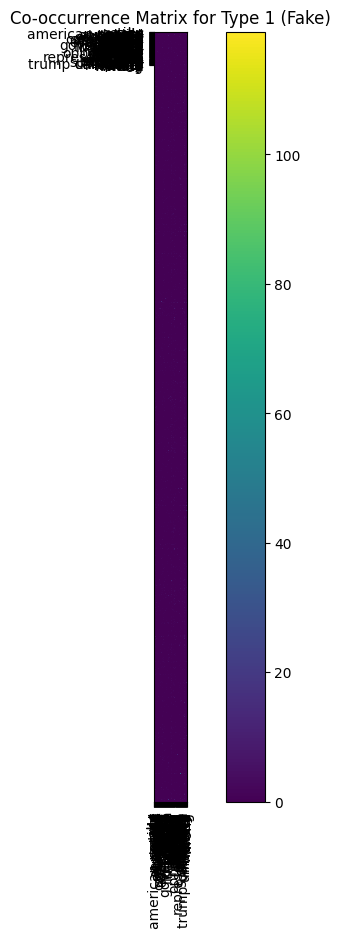

In [40]:
# Visualize co-occurrence matrix or word-context matrix for type 1
plt.figure(figsize=(10, 10))
plt.imshow(co_occurrence_matrix_type1.toarray(), cmap='viridis', interpolation='nearest')
plt.title('Co-occurrence Matrix for Type 1 (Fake)')
plt.colorbar()
subset_feature_names_type1 = feature_names_type1[::10]  # Select every 10th feature name
plt.xticks(ticks=range(0, len(feature_names_type1), 10), labels=subset_feature_names_type1, rotation=90)
plt.yticks(ticks=range(0, len(feature_names_type1), 10), labels=subset_feature_names_type1)
plt.show()



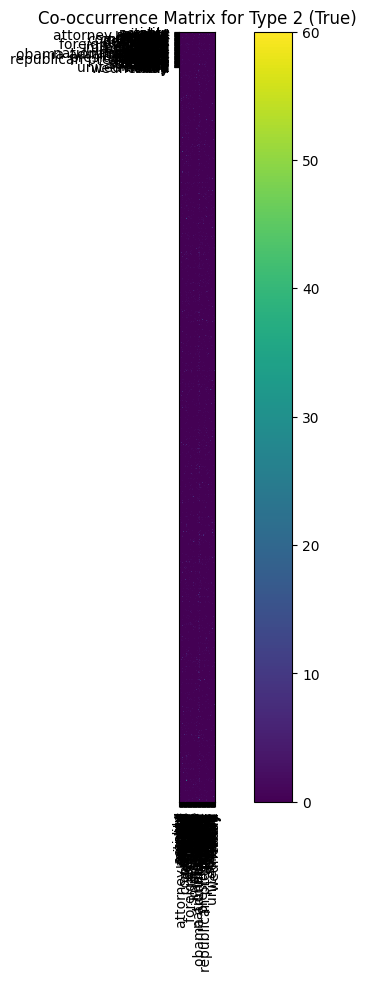

In [41]:
# Visualize co-occurrence matrix or word-context matrix for type 2
plt.figure(figsize=(10, 10))
plt.imshow(co_occurrence_matrix_type2.toarray(), cmap='viridis', interpolation='nearest')
plt.title('Co-occurrence Matrix for Type 2 (True)')
plt.colorbar()
subset_feature_names_type2 = feature_names_type2[::10]  # Select every 10th feature name
plt.xticks(ticks=range(0, len(feature_names_type2), 10), labels=subset_feature_names_type2, rotation=90)
plt.yticks(ticks=range(0, len(feature_names_type2), 10), labels=subset_feature_names_type2)
plt.show()

**N-gram Analysis**

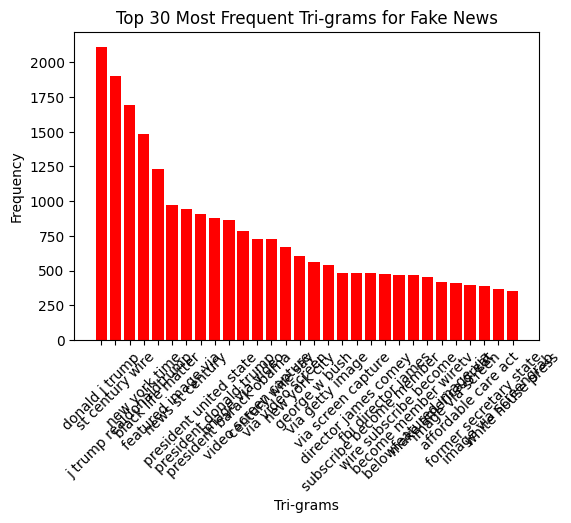

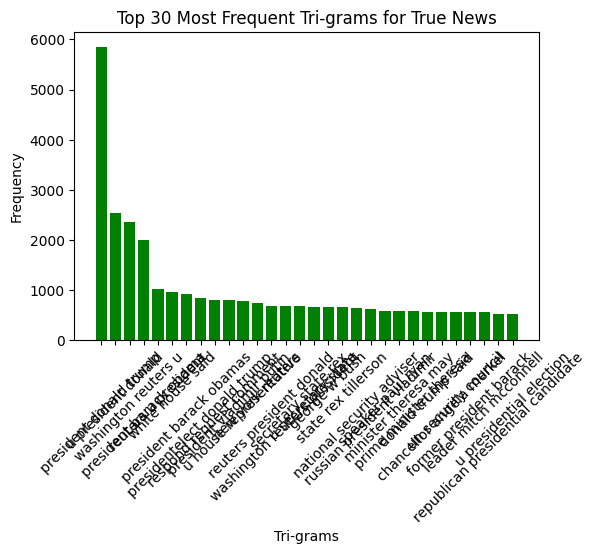

In [42]:
# Function to generate n-grams
def generate_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Function to analyze n-gram frequency for a specific type
def analyze_ngram_frequency(data, n):
    ngram_freq = Counter()
    for tokens in data:
        ngrams_list = generate_ngrams(tokens, n)
        ngram_freq.update(ngrams_list)
    return ngram_freq

# Specify the types for which you want to analyze n-gram frequency
types_to_analyze = ['fake', 'true']

# Plot top N most common tri-grams for each type with different colors
colors = ['red', 'green']

for i, t in enumerate(types_to_analyze):
    # Filter data by type
    filtered_data = df[df['Type'] == t]

    # Analyze tri-gram frequency for the filtered data
    trigram_freq = analyze_ngram_frequency(filtered_data['Tokens'], 3)

    # Get top N most common tri-grams
    top_n_trigrams = trigram_freq.most_common(30)

    # Plot bar chart for top N most common tri-grams with different colors
    plt.figure(figsize=(6, 4))
    plt.bar([' '.join(ngram[0]) for ngram in top_n_trigrams], [ngram[1] for ngram in top_n_trigrams], color=colors[i])
    plt.title(f'Top 30 Most Frequent Tri-grams for {t.capitalize()} News')
    plt.xlabel('Tri-grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# **Feature Extraction**

**Bag-of-Words (BoW)**

In [43]:
# Function to perform Bag-of-Words feature extraction for a specific type
def perform_bow_extraction(data):
    # Extracting the text data
    X = data['Content']  # Content column containing the text data

    # Initialize CountVectorizer to create BoW features
    vectorizer = CountVectorizer()

    # Fit and transform the text data to generate BoW features
    X_bow = vectorizer.fit_transform(X)

    # Print the shape of the BoW matrix
    print("Shape of BoW matrix:", X_bow.shape)

    # Optionally, print feature names
    print("Feature names:", vectorizer.get_feature_names_out())

# Filter data for 'fake' type and perform BoW feature extraction
print("Bag-of-Words Feature Extraction for 'fake' Type:")
perform_bow_extraction(df[df['Type'] == 'fake'])

# Filter data for 'true' type and perform BoW feature extraction
print("\nBag-of-Words Feature Extraction for 'true' Type:")
perform_bow_extraction(df[df['Type'] == 'true'])

Bag-of-Words Feature Extraction for 'fake' Type:
Shape of BoW matrix: (22850, 175493)
Feature names: ['aa' 'aaa' 'aaaaackkk' ... 'zzzzaaaacccchhh' 'zzzzzzzz' 'zzzzzzzzzzzzz']

Bag-of-Words Feature Extraction for 'true' Type:
Shape of BoW matrix: (21416, 78035)
Feature names: ['aa' 'aaa' 'aab' ... 'zypries' 'zyries' 'zyuganov']


**TF-IDF (Term Frequency-Inverse Document Frequency)**

In [44]:
# Function to perform TF-IDF feature extraction for a specific type
def perform_tfidf_extraction(data):
    # Extracting the text data
    X = data['Content']  # Content column containing the text data

    # Initialize TfidfVectorizer to create TF-IDF features
    vectorizer = TfidfVectorizer()

    # Fit and transform the text data to generate TF-IDF features
    X_tfidf = vectorizer.fit_transform(X)

    # Print the shape of the TF-IDF matrix
    print("Shape of TF-IDF matrix:", X_tfidf.shape)

    # Optionally, print feature names
    print("Feature names:", vectorizer.get_feature_names_out())

# Filter data for 'fake' type and perform TF-IDF feature extraction
print("TF-IDF Feature Extraction for 'fake' Type:")
perform_tfidf_extraction(df[df['Type'] == 'fake'])

# Filter data for 'true' type and perform TF-IDF feature extraction
print("\nTF-IDF Feature Extraction for 'true' Type:")
perform_tfidf_extraction(df[df['Type'] == 'true'])

TF-IDF Feature Extraction for 'fake' Type:
Shape of TF-IDF matrix: (22850, 175493)
Feature names: ['aa' 'aaa' 'aaaaackkk' ... 'zzzzaaaacccchhh' 'zzzzzzzz' 'zzzzzzzzzzzzz']

TF-IDF Feature Extraction for 'true' Type:
Shape of TF-IDF matrix: (21416, 78035)
Feature names: ['aa' 'aaa' 'aab' ... 'zypries' 'zyries' 'zyuganov']
